In [1]:
import sys
sys.path.append('../')

In [2]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import VarFourier

In [121]:
class interpolation():
    def __init__(self, base_ansatz, extra_qubits) -> None:
        self.base_ansatz = base_ansatz
        self.extra_qubits = extra_qubits
        self.num_qubits_tot = self.base_ansatz.num_qubits + self.extra_qubits
        self.num_params = self.base_ansatz.num_params

    
    def construct_circuit(self, params):
        
        # Make previous circuit
        self.base_ansatz.construct_circuit(params)
        
        qml.Barrier()

        # now we transform to momentum space
        QFT( self.num_qubits_tot , n_init=self.extra_qubits )
        #qml.QFT(range(self.extra_qubits,self.num_qubits_tot))
        qml.Barrier()
        # we entangle everything
        last_qubit_prev = self.base_ansatz.num_qubits - 1
        
        for wire in range(0,self.extra_qubits):
            #qml.CNOT([self.num_qubits_tot-1, wire])
            qml.CNOT([self.extra_qubits, wire])
            pass
        
        # and finnaly we undo the QFT
        
        qml.Barrier()
        QFT(self.num_qubits_tot, inverse = True, n_init=0)
        #qml.adjoint( qml.QFT( range(self.num_qubits_tot) ) )


def QFT(n_wires, semi_classical=False, inverse=False, n_init=0):
    if semi_classical:
        mid_measures = []
        for n in range( n_init, n_wires ):
            qml.Hadamard( wires=n )
            if n < n_wires-1:
                mid_measure = qml.measure( wires=n ) 
                mid_measures.append( mid_measure )
                for m in range(1,n_wires-n):
                    qml.cond( mid_measure, 
                                qml.PhaseShift )( np.pi/2**m, 
                                            wires=n+m ) 
    else:

        if inverse:
            for n in reversed(range( n_init , n_wires )):
                for m in reversed(range(1,n_wires-n)):
                    qml.ControlledPhaseShift( -np.pi/2**m, 
                                                wires=[n,n+m]  )
                qml.Hadamard(wires=n)

        else:
            for n in range( n_init , n_wires ):
                qml.Hadamard(wires=n)
                for m in range(1,n_wires-n):
                    qml.ControlledPhaseShift( np.pi/2**m, 
                                                wires=[n,n+m]  )

In [122]:
class RY_ansatz:
    def __init__( self, num_qubits, depth=1 , n_initial=0):
        self.n_initial = n_initial
        self.num_qubits = num_qubits - n_initial 
        self.depth = depth
        self.num_params = (num_qubits - n_initial ) * depth
    def construct_circuit( self, params ):
        params = np.array(params).reshape(self.depth,self.num_qubits)
        for layer, params_per_layer in enumerate(params):
            for wire in range(self.n_initial , self.num_qubits+self.n_initial):
                qml.RY(params_per_layer[wire-self.n_initial], wires=wire)
            if layer < len(params)-1:
                for wire in range(self.n_initial , self.num_qubits+self.n_initial-1):
                    qml.CNOT([wire,wire+1])
                #qml.CNOT([self.num_qubits-1,0]) 

In [123]:
num_qubits = 4

In [124]:
def init_state():
    #qml.AmplitudeEmbedding(features=vecs[:,0], wires=range(num_qubits))
    pass 

In [125]:
num_layers = 4
var_state_class = RY_ansatz(num_qubits, num_layers, n_initial=0)
#var_state_class = symmetric_ansatz(var_state_class)

#var_state_class = Rot_ansatz(num_qubits,num_layers)
#var_state_class = RY_ansatz(num_qubits,num_layers)
var_state = var_state_class.construct_circuit
num_params = var_state_class.num_params


(<Figure size 1400x500 with 1 Axes>, <Axes: >)

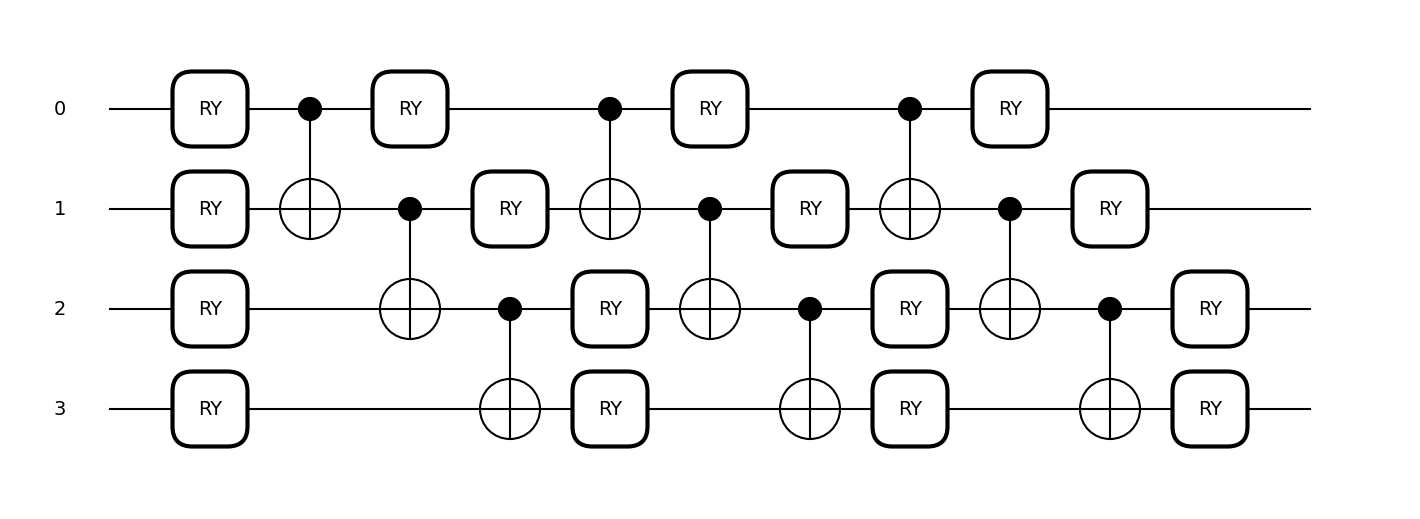

In [126]:
qml.draw_mpl( var_state )( num_params*[0] )

In [127]:
device = qml.device( "lightning.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : 0.5*(x**2),
                    lambda p : 0.5*(p**2),
                    device,
                    xmin=-2,
                    xmax=2,
                    var_state  = var_state,
                    init_state = init_state,
                    semi_classical=False
                    )

In [128]:
vals, vecs = varqft.energy_eigens()
val = vals[0]
vec = vecs[:,0]
vals

array([ 0.47119303,  1.67790653,  2.1415672 ,  5.07935819,  5.16615628,
       10.51532084, 10.53803896, 18.10996143, 18.11244954, 27.86055687,
       27.87437358, 39.7705857 , 39.81635601, 53.78689423, 53.99143427,
       70.17838693])

In [129]:
beta = np.exp(-0.5*np.sqrt(np.abs(val)))/(2*np.sqrt(np.abs(val)))

In [130]:
beta

0.5167888119994999

In [131]:
1/16

0.0625

In [132]:
vals[3]/vals[0]

10.77978198897208

In [133]:
params_init = np.random.randn( num_params )*0.001
#params_pre = params_ground[-1]
#params_ground, energies_ground = varqft.run( np.concatenate((params_pre,np.random.randn(num_qubits)*1e-3)), max_iterations=500, learning_rate=0.5, conv_tol=1e-6 )
params_ground, energies_ground = varqft.run( params_init , max_iterations=300, learning_rate=0.2, conv_tol=1e-6 )

In [134]:
#params_init

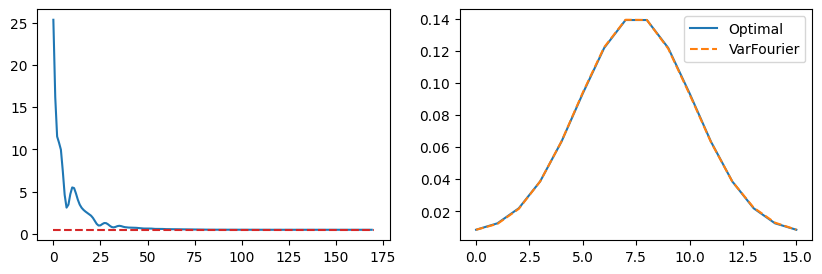

In [135]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

ground_state = varqft.state( params_ground[-1] )

ax[1].plot( np.abs(vecs[:,0])**2) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

In [136]:
abs(np.vdot( ground_state, vec ))**2

0.999987989922668

In [137]:
varqft.energy_eval(params_ground[-1])

Array(0.47129813, dtype=float32)

In [151]:
num_layers = 4
extra = 2
var_state_class = RY_ansatz(num_qubits+extra, num_layers, n_initial=extra)

var_state_interpol = interpolation(var_state_class, extra_qubits=extra)

#var_state_class = Rot_ansatz(num_qubits,num_layers)
#var_state_class = RY_ansatz(num_qubits,num_layers)
var_state_interp = var_state_interpol.construct_circuit
#num_params = var_state_class.num_params


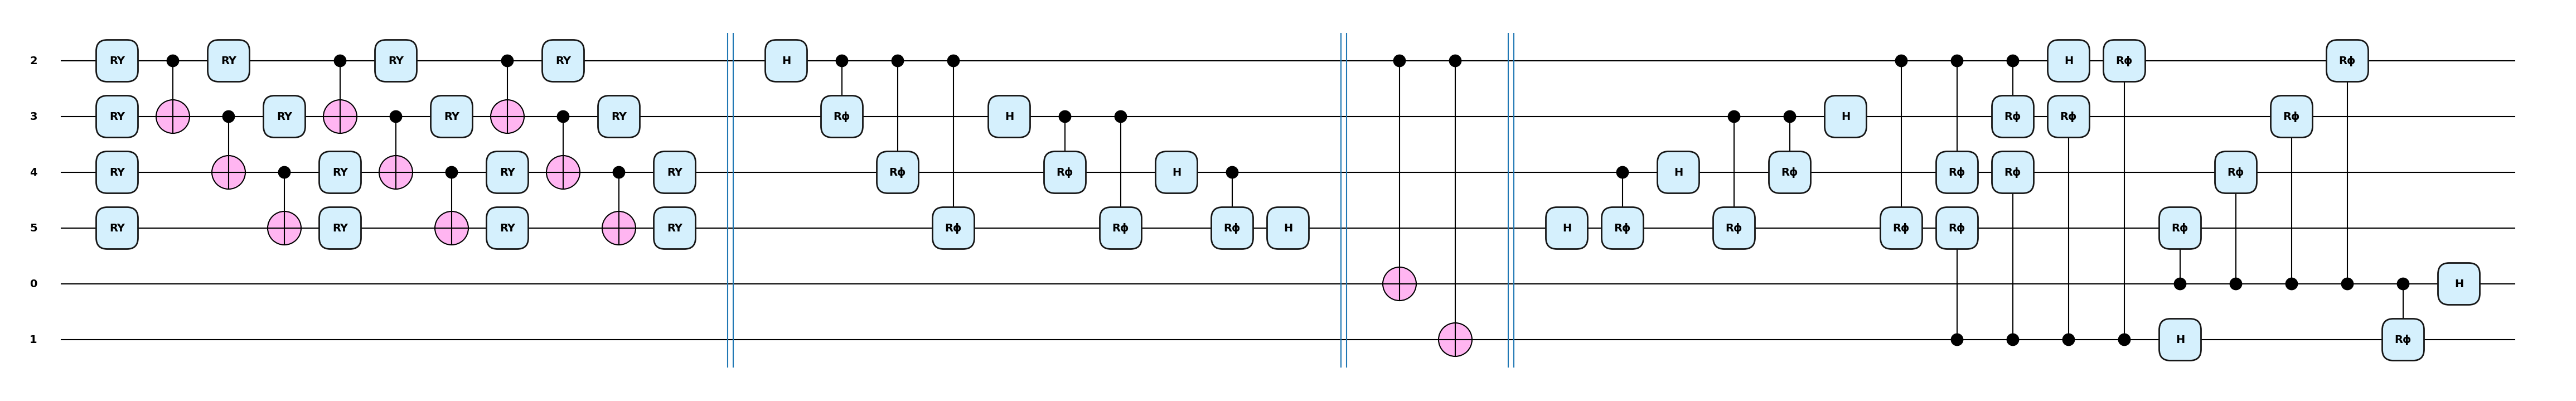

In [152]:
fig, ax = qml.draw_mpl( var_state_interp , style='pennylane' )( params_ground[-1] )
fig.show()

In [153]:
device2 = qml.device( "lightning.qubit", 
                    wires=num_qubits + extra)

varqft2 = VarFourier( num_qubits+extra,
                    lambda x : 0.5*(x**2),
                    lambda p : 0.5*(p**2),
                    device2,
                    xmin=-2,
                    xmax=2,
                    var_state  = var_state_interp,
                    init_state = init_state,
                    semi_classical=False
                    )

In [154]:
vals2, vecs2 = varqft2.energy_eigens()
val2 = vals2[0]
vec2 = vecs2[:,0]
vals2

array([4.58906804e-01, 1.74137569e+00, 2.14485116e+00, 5.45288964e+00,
       5.53135903e+00, 1.14423052e+01, 1.14701292e+01, 1.98130221e+01,
       1.98272302e+01, 3.05729827e+01, 3.05815777e+01, 4.37233553e+01,
       4.37290673e+01, 5.92644336e+01, 5.92684557e+01, 7.71963188e+01,
       7.71992568e+01, 9.75190536e+01, 9.75212478e+01, 1.20232659e+02,
       1.20234314e+02, 1.45337145e+02, 1.45338391e+02, 1.72832520e+02,
       1.72833442e+02, 2.02718788e+02, 2.02719440e+02, 2.34995952e+02,
       2.34996371e+02, 2.69664015e+02, 2.69664223e+02, 3.06722979e+02,
       3.06722987e+02, 3.46172655e+02, 3.46172848e+02, 3.88013222e+02,
       3.88013624e+02, 4.32244680e+02, 4.32245313e+02, 4.78867022e+02,
       4.78867919e+02, 5.27880238e+02, 5.27881452e+02, 5.79284314e+02,
       5.79285924e+02, 6.33079228e+02, 6.33081356e+02, 6.89264947e+02,
       6.89267781e+02, 7.47841411e+02, 7.47845259e+02, 8.08808507e+02,
       8.08813901e+02, 8.72166002e+02, 8.72173941e+02, 9.37913335e+02,
      

In [155]:
varqft2.energy_eval(params_ground[-1])

Array(5.3679256, dtype=float32)

In [156]:
ground_state = varqft.state( params_ground[-1] )


In [157]:
@qml.qnode(device2)
def get_state(params):
    var_state_interp(params)
    return qml.state()

In [158]:
np.abs(vecs2[:,0])**2

tensor([0.00282866, 0.00289894, 0.00303758, 0.00324472, 0.00352267,
        0.00387527, 0.00430747, 0.00482493, 0.00543353, 0.00613902,
        0.00694651, 0.00786007, 0.00888222, 0.01001348, 0.01125195,
        0.01259294, 0.01402859, 0.01554771, 0.01713562, 0.01877421,
        0.02044209, 0.02211497, 0.02376609, 0.02536693, 0.02688795,
        0.02829947, 0.02957265, 0.03068044, 0.03159854, 0.03230631,
        0.03278751, 0.03303096, 0.03303096, 0.03278751, 0.03230631,
        0.03159854, 0.03068044, 0.02957265, 0.02829947, 0.02688795,
        0.02536693, 0.02376609, 0.02211497, 0.02044209, 0.01877421,
        0.01713562, 0.01554771, 0.01402859, 0.01259294, 0.01125195,
        0.01001348, 0.00888222, 0.00786007, 0.00694651, 0.00613902,
        0.00543353, 0.00482493, 0.00430747, 0.00387527, 0.00352267,
        0.00324472, 0.00303758, 0.00289894, 0.00282866], requires_grad=True)

In [159]:
np.abs(get_state(params_ground[-1]))**2

tensor([0.00211593, 0.00362712, 0.00688819, 0.01078638, 0.01397388,
        0.015436  , 0.01424568, 0.01078412, 0.00691093, 0.00465236,
        0.00555419, 0.00967649, 0.0156689 , 0.02150049, 0.02452266,
        0.02326127, 0.01848708, 0.01273786, 0.00935311, 0.01035995,
        0.0156689 , 0.02349662, 0.0303441 , 0.03295291, 0.03006323,
        0.02314725, 0.0160596 , 0.01243641, 0.01397388, 0.02025508,
        0.02829988, 0.03418181, 0.03485823, 0.02978285, 0.02174508,
        0.0146895 , 0.01157676, 0.01367472, 0.01958748, 0.02622809,
        0.03006323, 0.02875762, 0.02307908, 0.01579939, 0.00988174,
        0.00761023, 0.0093105 , 0.01375093, 0.01848708, 0.02067212,
        0.01928016, 0.01511592, 0.00988174, 0.0056141 , 0.00348905,
        0.00405929, 0.00691093, 0.01026273, 0.01257368, 0.01303946,
        0.01157676, 0.00885564, 0.00553327, 0.0028304 ], dtype=float32, requires_grad=True)

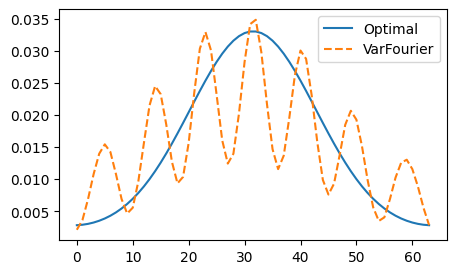

In [160]:
fig, ax = plt.subplots( 1, 1, figsize=(5,3) ) 

ground_state2 = varqft2.state( params_ground[-1] )

ax.plot( np.abs(vecs2[:,0])**2) 
ax.plot( np.abs(ground_state2)**2, '--' ) 
ax.legend(['Optimal','VarFourier']) 